**Dengue is a mosquito-borne viral disease that remains one of the most persistent public health threats worldwide, especially in tropical regions. According to the World Health Organization, dengue infects over 100 million people globally every year, with increasing incidence primarily driven by factors such as climate change, rapid urbanization, and increased human mobility. In the Philippines, the disease is endemic, and its cyclical spikes consistently strain the country's healthcare system as it is among the leading causes of hospitalization among children. While recent progress in vaccine development and the emergence of innovative vector control strategies may offer an optimistic outlook, effective surveillance and a deeper understanding of the available data are still crucial components of any holistic dengue response program.**

**This project leverages Python-based tools to conduct a comprehensive data analysis in pursuit of the following primary objectives:**
- **Extract valuable insights from the datasets that can be useful in forming actionable recommendations**
- **Determine whether rainfall intensity is a strong indicator of dengue incidence in the Philippines**
- **Generate machine learning models to forecast future dengue cases and potential outbreaks** 

**The project was dividend into four sections. The first three sections involves data cleaning, visualization, and analysis focused on a distinct set of data before they were ultimately integrated in the final section for the complete analysis. To begin this section, I imported all modules needed throughout this section of the project.**

In [2]:
!pip install ruptures

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import ruptures as rpt

**I loaded two of the most comprehensive publicly available datasets on dengue in the Philippines. The first dataset, loaded as "df1", was sourced from the Humanitarian Data Exchange, which in turn obtained it from the Philippine Department of Health (DOH) - Epidemiology Bureau. It contains detailed records of both case counts and deaths nationwide from 2016 to 2021. The second dataset, loaded as "df2", also came from the DOH Epidemiology Bureau but was accessed via the Philippine government’s Freedom of Information (FOI) website portal. Unlike the first, it only includes case counts but covers a longer time span (2017-2024). I obtained both datasets with the intention of combining them into an expansive dataset that would hopefully enable the development of a reliable model for forecasting future dengue cases and potential outbreaks.**

In [4]:
df1=pd.read_csv('/Users/jmtee/Desktop/Dengue project/PH Dengue cases 2016-2021.csv') #2016-2021 cases
df2=pd.read_csv('/Users/jmtee/Desktop/Dengue project/PH Dengue cases 2017-2024.csv') #2017-2024 cases

**Upon loading the datasets, my first goal was to merge them before proceeding to a comprehensive data cleanup. The initial step in this process was to ensure that the join key, i.e. the province name, was complete and consistent across both datasets to allow for proper alignment. To check this, I inspected each dataset individually. A quick look at df1 showed that it was already fairly well-organized. However, it was immediately apparent that the first row was not part of the actual data and should be excluded from any further processing.**

In [6]:
df1.head()

,loc,cases,deaths,date,Region
0,#adm2+name,#affected+infected,#affected+killed,#date,#region
1,ALBAY,15,0,1/10/2016,REGION V-BICOL REGION
2,ALBAY,13,0,1/17/2016,REGION V-BICOL REGION
3,ALBAY,9,0,1/24/2016,REGION V-BICOL REGION
4,ALBAY,14,0,1/31/2016,REGION V-BICOL REGION


In [7]:
df1 = df1.drop(index=0)
df1.head()

,loc,cases,deaths,date,Region
1,ALBAY,15,0,1/10/2016,REGION V-BICOL REGION
2,ALBAY,13,0,1/17/2016,REGION V-BICOL REGION
3,ALBAY,9,0,1/24/2016,REGION V-BICOL REGION
4,ALBAY,14,0,1/31/2016,REGION V-BICOL REGION
5,ALBAY,9,0,2/7/2016,REGION V-BICOL REGION


**After discarding the first row, df1 was in a readable and usable format for the next steps. I did a similar quick check on df2 and it turned out that it was already neatly curated. This is likely because the dataset was released in response to a public request under the Philippines' Freedom of Information (FOI) law. As such, the Department of Health (DOH) would have already organized and cleaned the data before providing it to the public.**

In [9]:
df2.head()

,Year,Month,Region,Province/HUC/ICC,Cases
0,2017,1,1,DAGUPAN CITY,22
1,2017,1,1,ILOCOS NORTE,16
2,2017,1,1,ILOCOS SUR,38
3,2017,1,1,LA UNION,71
4,2017,1,1,PANGASINAN,118


**Before proceeding with the merge, I needed to ensure that the province names in both datasets were identical and referred to the same geographic locations.**

In [11]:
print("In df1 but not in df2:")
print(sorted(set(df1['loc'].unique()) - set(df2['Province/HUC/ICC'].unique())))
print("\nIn df2 but not in df1:")
print(sorted(set(df2['Province/HUC/ICC'].unique()) - set(df1['loc'].unique())))

In df1 but not in df2:
[' CAGAYAN DE ORO CITY', ' NEGROS ORIENTAL', 'BASILIG CITY', 'BAYUGAN CITY', 'CABADBARAN CITY', 'GENERAL SANTOS CITY', 'ISABELA CITY', 'LAPU-LAPU CITY', 'LAS PINAS CITY', 'MAKATI CITY', 'MALABON CITY', 'MANDALUYONG CITY', 'MANILA CITY', 'MARIKINA CITY', 'MUNTINLUPA CITY', 'NAVOTAS CITY', 'NORTH COTABATO', 'NUEVA VISCAYA', 'PARANAQUE CITY', 'PASIG CITY', 'SAMAR', 'SAN JUAN CITY', 'SANTIAGO CITY', 'SISQUIJOR', 'SURIGAO CITY', 'TACLOBAN', 'TANDAG CITY', 'VALENZUELA CITY']

In df2 but not in df1:
['CAGAYAN DE ORO CITY', 'CITY OF ISABELA', 'CITY OF ISABELA (NOT A PROVINCE)', 'CITY OF LAS PIÑAS', 'CITY OF MAKATI', 'CITY OF MALABON', 'CITY OF MANDALUYONG', 'CITY OF MANILA', 'CITY OF MARIKINA', 'CITY OF MUNTINLUPA', 'CITY OF NAVOTAS', 'CITY OF PARAÑAQUE', 'CITY OF PASIG', 'CITY OF SAN JUAN', 'CITY OF SANTIAGO', 'CITY OF VALENZUELA', 'COTABATO (NORTH COTABATO)', 'GENERAL SANTOS CITY (DADIANGAS)', 'LAPU-LAPU CITY (OPON)', 'NEGROS ORIENTAL', 'NUEVA VIZCAYA', 'SAMAR (WESTERN

**After an initial scan of the two datasets, it was clear that several province names did not match. Some of the discrepancies were only due to unnecessary spaces or misspellings. To address this, I first removed any extraneous whitespace, manually corrected typographical errors, and then standardized the province names to ensure proper subsequent mapping.**

In [13]:
df1['loc'] = df1['loc'].str.strip()
df2['Province/HUC/ICC'] = df2['Province/HUC/ICC'].str.strip()

In [14]:
print("In df1 but not in df2:")
print(sorted(set(df1['loc'].unique()) - set(df2['Province/HUC/ICC'].unique())))
print("\nIn df2 but not in df1:")
print(sorted(set(df2['Province/HUC/ICC'].unique()) - set(df1['loc'].unique())))

In df1 but not in df2:
['BASILIG CITY', 'BAYUGAN CITY', 'CABADBARAN CITY', 'GENERAL SANTOS CITY', 'ISABELA CITY', 'LAPU-LAPU CITY', 'LAS PINAS CITY', 'MAKATI CITY', 'MALABON CITY', 'MANDALUYONG CITY', 'MANILA CITY', 'MARIKINA CITY', 'MUNTINLUPA CITY', 'NAVOTAS CITY', 'NORTH COTABATO', 'NUEVA VISCAYA', 'PARANAQUE CITY', 'PASIG CITY', 'SAMAR', 'SAN JUAN CITY', 'SANTIAGO CITY', 'SISQUIJOR', 'SURIGAO CITY', 'TACLOBAN', 'TANDAG CITY', 'VALENZUELA CITY']

In df2 but not in df1:
['CITY OF ISABELA', 'CITY OF ISABELA (NOT A PROVINCE)', 'CITY OF LAS PIÑAS', 'CITY OF MAKATI', 'CITY OF MALABON', 'CITY OF MANDALUYONG', 'CITY OF MANILA', 'CITY OF MARIKINA', 'CITY OF MUNTINLUPA', 'CITY OF NAVOTAS', 'CITY OF PARAÑAQUE', 'CITY OF PASIG', 'CITY OF SAN JUAN', 'CITY OF SANTIAGO', 'CITY OF VALENZUELA', 'COTABATO (NORTH COTABATO)', 'GENERAL SANTOS CITY (DADIANGAS)', 'LAPU-LAPU CITY (OPON)', 'NUEVA VIZCAYA', 'SAMAR (WESTERN SAMAR)', 'SIQUIJOR', 'TACLOBAN CITY']


In [15]:
location_name = {"SISQUIJOR":"SIQUIJOR", "NUEVA VISCAYA":"NUEVA VIZCAYA", "GENERAL SANTOS CITY (DADIANGAS)":"GENERAL SANTOS CITY",
                 "CITY OF MAKATI":"MAKATI CITY", "CITY OF MANDALUYONG":"MANDALUYONG CITY", "CITY OF PASIG":"PASIG CITY", "CITY OF SAN JUAN":"SAN JUAN CITY",
                 "CITY OF MARIKINA":"MARIKINA CITY", "CITY OF MUNTINLUPA":"MUNTINLUPA CITY", "CITY OF NAVOTAS":"NAVOTAS CITY", "CITY OF MALABON":"MALABON CITY",
                 "CITY OF LAS PIÑAS":"LAS PIÑAS CITY", "LAS PINAS CITY":"LAS PIÑAS CITY", "PARANAQUE CITY":"PARAÑAQUE CITY", "CITY OF PARAÑAQUE":"PARAÑAQUE CITY",
                 "CITY OF VALENZUELA":"VALENZUELA CITY", "TACLOBAN":"TACLOBAN CITY", "SAMAR (WESTERN SAMAR)":"WESTERN SAMAR", "SAMAR":"WESTERN SAMAR",
                 "LAPU-LAPU CITY (OPON)":"LAPU-LAPU CITY", "COTABATO (NORTH COTABATO)":"NORTH COTABATO", "CITY OF SANTIAGO":"SANTIAGO CITY",
                 "MANILA CITY":"CITY OF MANILA", "ISABELA CITY":"BASILAN", "CITY OF ISABELA":"BASILAN", "CITY OF ISABELA (NOT A PROVINCE)":"BASILAN",
                 "TANDAG CITY":"SURIGAO DEL SUR", "SURIGAO CITY":"SURIGAO DEL NORTE","CABADBARAN CITY":"AGUSAN DEL NORTE", "BAYUGAN CITY":"AGUSAN DEL SUR",
                 "BASILIG CITY":"SURIGAO DEL SUR"
                }
df1["unified_name"] = df1["loc"].replace(location_name)
df2["unified_name"] = df2["Province/HUC/ICC"].replace(location_name)

**After creating a dictionary for the corrected and unified province names, I mapped it to both datasets, creating a new column called "unified_name." This column will serve as the join key during the merge. Below is a quick preview of how this looks in df2. Notice, for example, that CITY OF SANTIAGO was converted to the standardized name SANTIAGO CITY.**

In [17]:
df2.head(10)

,Year,Month,Region,Province/HUC/ICC,Cases,unified_name
0,2017,1,1,DAGUPAN CITY,22,DAGUPAN CITY
1,2017,1,1,ILOCOS NORTE,16,ILOCOS NORTE
2,2017,1,1,ILOCOS SUR,38,ILOCOS SUR
3,2017,1,1,LA UNION,71,LA UNION
4,2017,1,1,PANGASINAN,118,PANGASINAN
5,2017,1,2,CAGAYAN,133,CAGAYAN
6,2017,1,2,CITY OF SANTIAGO,8,SANTIAGO CITY
7,2017,1,2,ISABELA,98,ISABELA
8,2017,1,2,NUEVA VIZCAYA,14,NUEVA VIZCAYA
9,2017,1,2,QUIRINO,15,QUIRINO


**Creating the mapping dictionary took some time, as I needed to ensure all province names were accounted for, especially since the names would serve as the join keys. The code below helped me verify that no location names from either dataset were inadvertently omitted.**

In [19]:
print("In df1 but not in df2:")
print(set(df1["unified_name"]).difference(set(df2["unified_name"])))
print("\nIn df2 but not in df1:")
print(set(df2["unified_name"]).difference(set(df1["unified_name"])))

In df1 but not in df2:
set()

In df2 but not in df1:
set()


**The code below provides a glimpse of the changes made to both datasets. These range from simple edits, like adding or dropping a letter, to removing parenthetical information, to completely converting the naming convention.**

In [21]:
print(df1[df1["loc"] != df1["unified_name"]][["loc", "unified_name"]].drop_duplicates())
print(df2[df2["Province/HUC/ICC"] != df2["unified_name"]][["Province/HUC/ICC", "unified_name"]].drop_duplicates())

                  loc       unified_name
1197    NUEVA VISCAYA      NUEVA VIZCAYA
2757        SISQUIJOR           SIQUIJOR
3069            SAMAR      WESTERN SAMAR
3173         TACLOBAN      TACLOBAN CITY
3225     ISABELA CITY            BASILAN
4415     BASILIG CITY    SURIGAO DEL SUR
4466     BAYUGAN CITY     AGUSAN DEL SUR
4619  CABADBARAN CITY   AGUSAN DEL NORTE
5027   LAS PINAS CITY     LAS PIÑAS CITY
5282      MANILA CITY     CITY OF MANILA
5588   PARANAQUE CITY     PARAÑAQUE CITY
6098     SURIGAO CITY  SURIGAO DEL NORTE
6302      TANDAG CITY    SURIGAO DEL SUR
                      Province/HUC/ICC         unified_name
6                     CITY OF SANTIAGO        SANTIAGO CITY
37               LAPU-LAPU CITY (OPON)       LAPU-LAPU CITY
46               SAMAR (WESTERN SAMAR)        WESTERN SAMAR
49                     CITY OF ISABELA              BASILAN
66           COTABATO (NORTH COTABATO)       NORTH COTABATO
67     GENERAL SANTOS CITY (DADIANGAS)  GENERAL SANTOS CITY
102   

**After confirming that the join key was clean and ready, I quickly reviewed the column data types and missing values in both datasets individually. In df1, all columns were initially of object type, so I converted the case and death counts to integers since these represent human counts. I also transformed the date column to a datetime type and extracted the year and month as separate integer columns to allow flexibility for future time-based analyses. Regarding missing data, there was only one missing value in the entire dataset — a single death count. Given that most death counts in other rows were zero and this missing entry was clearly an anomaly, I simply replaced the missing value with 0.**

In [23]:
df1.info()
df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32701 entries, 1 to 32701
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   loc           32701 non-null  object
 1   cases         32701 non-null  object
 2   deaths        32700 non-null  object
 3   date          32701 non-null  object
 4   Region        32701 non-null  object
 5   unified_name  32701 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


loc             0
cases           0
deaths          1
date            0
Region          0
unified_name    0
dtype: int64

In [24]:
df1['deaths'] = df1['deaths'].fillna(0)
df1['cases'] = pd.to_numeric(df1['cases'], errors="coerce")
df1['deaths'] = pd.to_numeric(df1['deaths'], errors="coerce")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df1["year"] = df1["date"].dt.year
df1["month"] = df1["date"].dt.month
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32701 entries, 1 to 32701
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   loc           32701 non-null  object        
 1   cases         32701 non-null  int64         
 2   deaths        32701 non-null  int64         
 3   date          32701 non-null  datetime64[ns]
 4   Region        32701 non-null  object        
 5   unified_name  32701 non-null  object        
 6   year          32701 non-null  int32         
 7   month         32701 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(2), object(3)
memory usage: 1.7+ MB


**I did a similar review for df2. This dataset had no missing values and already included the date information split into year and month columns, both properly typed as integers. Henece, the only modification needed was converting the case counts to integers.**

In [26]:
df2.info()
df2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11246 entries, 0 to 11245
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              11246 non-null  int64 
 1   Month             11246 non-null  int64 
 2   Region            11246 non-null  object
 3   Province/HUC/ICC  11246 non-null  object
 4   Cases             11246 non-null  object
 5   unified_name      11246 non-null  object
dtypes: int64(2), object(4)
memory usage: 527.3+ KB


Year                0
Month               0
Region              0
Province/HUC/ICC    0
Cases               0
unified_name        0
dtype: int64

In [27]:
df2['Cases'] = df2['Cases'].str.replace(',', '')
df2['Cases'] = pd.to_numeric(df2['Cases'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11246 entries, 0 to 11245
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              11246 non-null  int64 
 1   Month             11246 non-null  int64 
 2   Region            11246 non-null  object
 3   Province/HUC/ICC  11246 non-null  object
 4   Cases             11246 non-null  int64 
 5   unified_name      11246 non-null  object
dtypes: int64(3), object(3)
memory usage: 527.3+ KB


**Just before merging, I grouped both datasets by province name, year, and month. I then aggregated the case and death counts by summing the grouped rows. This step ensured that the merged dataset contained only the necessary, consolidated information for further analysis.**

In [29]:
df1_grouped = df1.groupby(['unified_name', 'year', 'month']).agg({'cases':'sum','deaths':'sum'}).reset_index()
df2_grouped = df2.groupby(['unified_name', 'Year', 'Month', 'Region']).agg({'Cases':'sum'}).reset_index()

**However, a quick sampling from both datasets revealed a real major issue: case counts for the same province and time period DID NOT MATCH. Despite both datasets supposedly originating from the same source — the DOH Epidemiology Bureau — the records were not even remotely the same. For example, sampling one year from a single province showed that all 12 monthly entries had different case counts (see below).**

**I recognize that discrepancies like this may be common in real-world epidemiological datasets due to erratic real-time documentation, difficulties in data storage and transmission, or even limited site access or manpower, especially during outbreaks. However, I had expected a reasonable level of consistency given that both datasets come from the SAME government agency, an agency where accurate and reliable data are critical for shaping policy and response.**

**Nevertheless, since I have no control and knowledge on the reasons behind the differences in the records, I decided to proceed with the dataset that has the more recent records to better align with my goal of modeling future disease incidence and outbreaks. Therefore, I chose to continue with df2, which also conveniently covers a longer period, from 2017 to 2024.**

In [31]:
albay1 = df1_grouped[(df1_grouped['unified_name'] == 'ALBAY') & (df1_grouped['year'] == 2019)]
albay1

,unified_name,year,month,cases,deaths
280,ALBAY,2019,1,43,0
281,ALBAY,2019,2,41,1
282,ALBAY,2019,3,60,3
283,ALBAY,2019,4,33,1
284,ALBAY,2019,5,34,1
285,ALBAY,2019,6,166,5
286,ALBAY,2019,7,300,1
287,ALBAY,2019,8,283,2
288,ALBAY,2019,9,357,5
289,ALBAY,2019,10,120,2


In [32]:
albay2 = df2_grouped[(df2_grouped['unified_name'] == 'ALBAY') & (df2_grouped['Year'] == 2019)]
albay2

,unified_name,Year,Month,Region,Cases
393,ALBAY,2019,1,5,69
394,ALBAY,2019,2,5,32
395,ALBAY,2019,3,5,53
396,ALBAY,2019,4,5,29
397,ALBAY,2019,5,5,62
398,ALBAY,2019,6,5,253
399,ALBAY,2019,7,5,343
400,ALBAY,2019,8,5,332
401,ALBAY,2019,9,5,216
402,ALBAY,2019,10,5,99


**Since I was now using only one dataset, merging was no longer necessary. However, I chose to standardize the analysis strictly at the provincial level. To do this, I remapped location names so that administratively-independent cities were reassigned to their corresponding geographic provinces. Finally, I converted all names to title case to keep the visuals clean and uncluttered.**

In [34]:
city_to_province = {"CITY OF MANILA":"NCR", "QUEZON CITY":"NCR", "MANDALUYONG CITY":"NCR", "MAKATI CITY":"NCR", "PASIG CITY":"NCR", "SAN JUAN CITY":"NCR", 
                    "MARIKINA CITY":"NCR", "PASAY CITY":"NCR", "NAVOTAS CITY":"NCR", "MALABON CITY":"NCR", "MUNTINLUPA CITY":"NCR", "VALENZUELA CITY":"NCR",
                    "PARAÑAQUE CITY":"NCR", "LAS PIÑAS CITY":"NCR", "TAGUIG CITY":"NCR", "PATEROS":"NCR", "CALOOCAN CITY":"NCR", "DAGUPAN CITY":"PANGASINAN", 
                    "SANTIAGO CITY":"ISABELA", "ANGELES CITY":"PAMPANGA", "OLONGAPO CITY":"ZAMBALES", "BACOLOD CITY":"NEGROS OCCIDENTAL", "LUCENA CITY":"QUEZON",
                    "ILOILO CITY":"ILOILO", "CEBU CITY":"CEBU", "LAPU-LAPU CITY":"CEBU", "MANDAUE CITY":"CEBU", "ORMOC CITY":"LEYTE", "TACLOBAN CITY":"LEYTE",
                    "NAGA CITY":"CAMARINES SUR", "ZAMBOANGA CITY":"ZAMBOANGA DEL SUR", "CAGAYAN DE ORO CITY":"MISAMIS ORIENTAL",  "DAVAO CITY":"DAVAO DEL SUR", 
                    "ILIGAN CITY":"LANAO DEL NORTE", "GENERAL SANTOS CITY":"SOUTH COTABATO", "BUTUAN CITY":"AGUSAN DEL NORTE", "PUERTO PRINCESA CITY":"PALAWAN", 
                    "COTABATO CITY":"MAGUINDANAO", "NORTH COTABATO":"COTABATO", "WESTERN SAMAR":"SAMAR", "BAGUIO CITY":"BENGUET",}

df2['Province'] = df2['unified_name'].replace(city_to_province).apply(lambda x: x if x == 'NCR' else x.title())
sorted(df2['Province'].unique())

['Abra',
 'Agusan Del Norte',
 'Agusan Del Sur',
 'Aklan',
 'Albay',
 'Antique',
 'Apayao',
 'Aurora',
 'Basilan',
 'Bataan',
 'Batanes',
 'Batangas',
 'Benguet',
 'Biliran',
 'Bohol',
 'Bukidnon',
 'Bulacan',
 'Cagayan',
 'Camarines Norte',
 'Camarines Sur',
 'Camiguin',
 'Capiz',
 'Catanduanes',
 'Cavite',
 'Cebu',
 'Cotabato',
 'Davao De Oro',
 'Davao Del Norte',
 'Davao Del Sur',
 'Davao Occidental',
 'Davao Oriental',
 'Dinagat Islands',
 'Eastern Samar',
 'Guimaras',
 'Ifugao',
 'Ilocos Norte',
 'Ilocos Sur',
 'Iloilo',
 'Isabela',
 'Kalinga',
 'La Union',
 'Laguna',
 'Lanao Del Norte',
 'Lanao Del Sur',
 'Leyte',
 'Maguindanao',
 'Marinduque',
 'Masbate',
 'Misamis Occidental',
 'Misamis Oriental',
 'Mountain Province',
 'NCR',
 'Negros Occidental',
 'Negros Oriental',
 'Northern Samar',
 'Nueva Ecija',
 'Nueva Vizcaya',
 'Occidental Mindoro',
 'Oriental Mindoro',
 'Palawan',
 'Pampanga',
 'Pangasinan',
 'Quezon',
 'Quirino',
 'Rizal',
 'Romblon',
 'Samar',
 'Sarangani',
 'Siqui

In [35]:
dengue = df2.groupby(['Province', 'Year', 'Month', 'Region']).agg({'Cases':'sum'}).reset_index()
dengue.head(20)

,Province,Year,Month,Region,Cases
0,Abra,2017,1,CAR,13
1,Abra,2017,2,CAR,11
2,Abra,2017,3,CAR,17
3,Abra,2017,4,CAR,2
4,Abra,2017,5,CAR,10
5,Abra,2017,6,CAR,15
6,Abra,2017,7,CAR,34
7,Abra,2017,8,CAR,137
8,Abra,2017,9,CAR,43
9,Abra,2017,10,CAR,36


In [36]:
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7706 entries, 0 to 7705
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Province  7706 non-null   object
 1   Year      7706 non-null   int64 
 2   Month     7706 non-null   int64 
 3   Region    7706 non-null   object
 4   Cases     7706 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 301.1+ KB


**After remapping, I renamed the grouped and aggregated dataframe (df2) to "dengue" and conducted some fundamental checks to ensure I could proceed safely. This included a basic describe() function review. While not many insights can be gathered yet at this stage, one figure immediately caught my attention: the maximum number of cases. It was 10,045 for a single month! Upon seeing that, I pulled up the details of that row and then did some research about it online. It turned out that Iloilo (and nearby provinces) had indeed experienced an extreme dengue health crisis during that period, which even triggered the local government to declare a “State of Calamity” in the province.**

**As a side note, the minimum monthly case count recorded in the dataset is 1. This meant that no province in the Philippines was ever completely free of dengue infection during the entire 8-year span (2017–2024).**

In [38]:
dengue.describe()

,Year,Month,Cases
count,7706.000000,7706.000000,7706.000000
mean,2020.451726,6.424215,235.522580
std,2.275466,3.420408,493.941153
min,2017.000000,1.000000,1.000000
25%,2018.000000,3.000000,24.000000
50%,2020.000000,6.000000,80.000000
75%,2022.000000,9.000000,244.000000
max,2024.000000,12.000000,10045.000000


In [39]:
max_row = dengue.loc[dengue['Cases'].idxmax()]
max_row

Province    Iloilo
Year          2019
Month            7
Region           6
Cases        10045
Name: 3518, dtype: object

**To begin with what I find to be the most mentally-demanding yet most mentally-satisfying part — visualization and analysis — I generated a basic chart showing annual dengue case totals. The chart reveals a clear upward trend from 2017 to 2019 followed by a significant drop in 2020 and 2021, which coincides with the COVID-19 lockdown period in the Philippines. Interestingly, despite the extreme mobility restrictions during that time, recorded dengue cases still nearly topped the 100,000 plateau. Once the restrictions were lifted, case counts promptly rebounded, reaching more than 200,000 in 2022 and 2023. By the end of 2024, cases had once again surpassed the 300,000 mark. Now, midway through 2025, reports suggest that the rising annual trajectory show no signs of slowing down.**

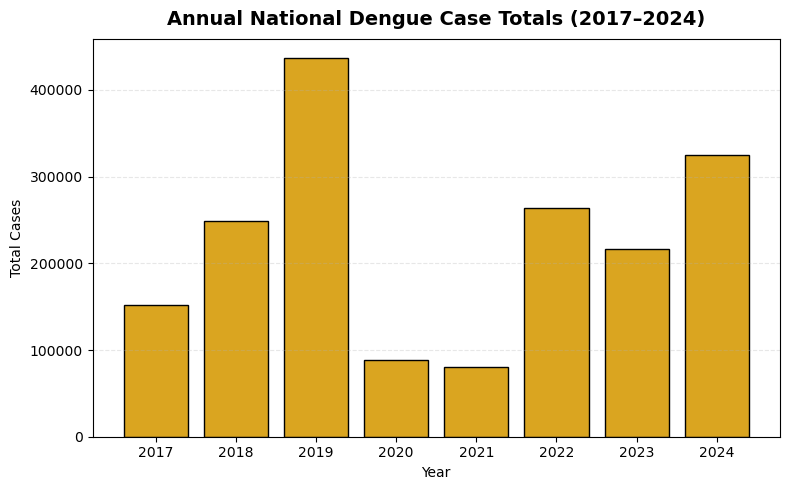

In [41]:
annual_totals = dengue.groupby('Year')['Cases'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(annual_totals['Year'], annual_totals['Cases'], color='goldenrod', edgecolor='black')
plt.title('Annual National Dengue Case Totals (2017–2024)', fontsize=14, weight='bold', pad=10)
plt.xlabel('Year')
plt.ylabel('Total Cases')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(annual_totals['Year'])
plt.tight_layout()
plt.show()

**I then continued the national-level analysis but on a more granular monthly scale. This allowed me to identify any potential recurring patterns across the eight years covered in the dataset. One immediate takeaway is the sharp exponential surges typical of infectious disease outbreaks, promptly followed by steep declines presumably when public health interventions, or even just community-level responses, kick in.**

**Another quite noticeable pattern is the rise in cases during the latter half of each year, which aligns with the Philippines’ monsoon season. Notably, this pattern still persisted even during the COVID-19 lockdown period (highlighted in light blue on the chart). Another insight we can infer is that outside of the lockdown era, national monthly totals have often exceeded 10,000 cases. However, as we learned earlier, July 2019 alarmingly stood out as the province of Iloilo alone recorded over 10,000 cases that month. Accordingly, the national total during that month was almost 80,000, hence, Iloilo by itself accounted for more than one-eighth of all cases in the country. The following month, August 2019, the Philippines recorded its highest monthly total ever, surpassing 80,000 cases. It was the only time in history that cases breached 80,000, until August 2024, when the national total once again surged past the 80,000 mark.**

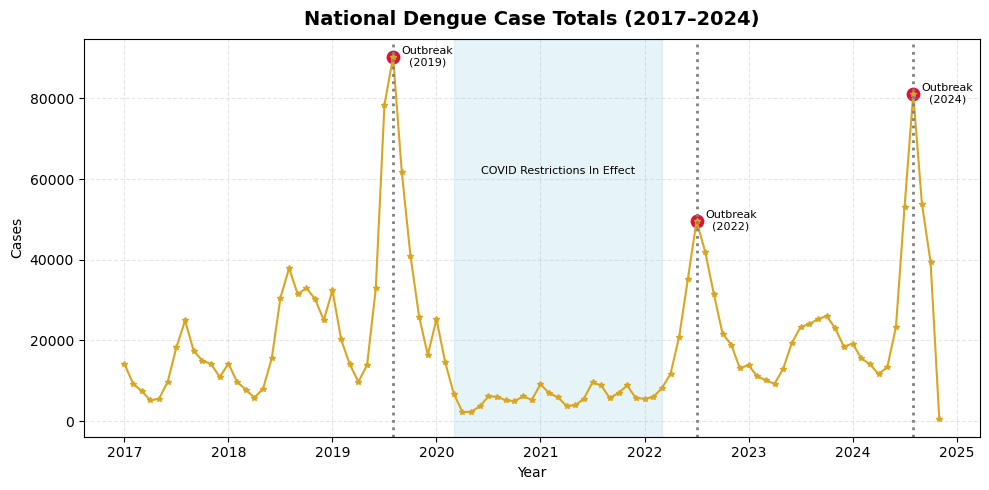

In [43]:
national_trend = dengue.groupby(['Year', 'Month'])['Cases'].sum().reset_index()
annual_total = national_trend.groupby('Year')['Cases'].sum()
outbreak_years = annual_total[annual_total > 200_000].index.tolist()
peak_months = national_trend[(national_trend['Year'].isin(outbreak_years)) & (national_trend['Cases'] > 40_000)]
peak_months = peak_months.loc[peak_months.groupby('Year')['Cases'].idxmax()]

plt.figure(figsize=(10, 5))
plt.plot(national_trend['Year'] + (national_trend['Month'] - 1) / 12, national_trend['Cases'], marker='*', linestyle='-', color='goldenrod', markersize=4)
plt.scatter(peak_months['Year'] + (peak_months['Month'] - 1) / 12, peak_months['Cases'], color='crimson', s=80)

for _, row in peak_months.iterrows():
    x = row['Year'] + (row['Month'] - 1) / 12
    plt.axvline(x, color='gray', linestyle=':', linewidth=2)
    plt.text(x + 0.33, row['Cases'], f"Outbreak\n({int(row['Year'])})",
             ha='center', va='center', fontsize=8, color='black')

plt.axvspan(2020 + 2/12, 2022 + 2/12, color='lightblue', alpha=0.3)
plt.text(2021 + 2/12, 0.7 * national_trend['Cases'].max(), 'COVID Restrictions In Effect', fontsize=8, color='black', ha='center', va='top')
plt.title('National Dengue Case Totals (2017–2024)', fontsize=14, weight='bold', pad=10)
plt.xlabel('Year')
plt.ylabel('Cases')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Next, I created a heatmap to visualize the burden and distribution of dengue cases across the provinces over the years. We immediately observe that practically in every year, even during lockdown years, the bulk of the cases were recorded from the National Capital Region (NCR). It is very important to emphasize that these are raw case counts rather than incidence rates. The incidence analysis will be explored and discussed during the latter section of this project as I have had to separately collect population data from a different source. At this stage, we are only dealing with absolute case counts so it is unsurprising that the provinces with the highest case burdens are either highly-populated metropolitan areas or emerging provinces that include increasingly urbanized component cities. Further, it is also noticeable that there are overall more darker shaded provinces during 2019, 2022, and 2024, reflecting the outbreaks that we observed in the previous chart.**

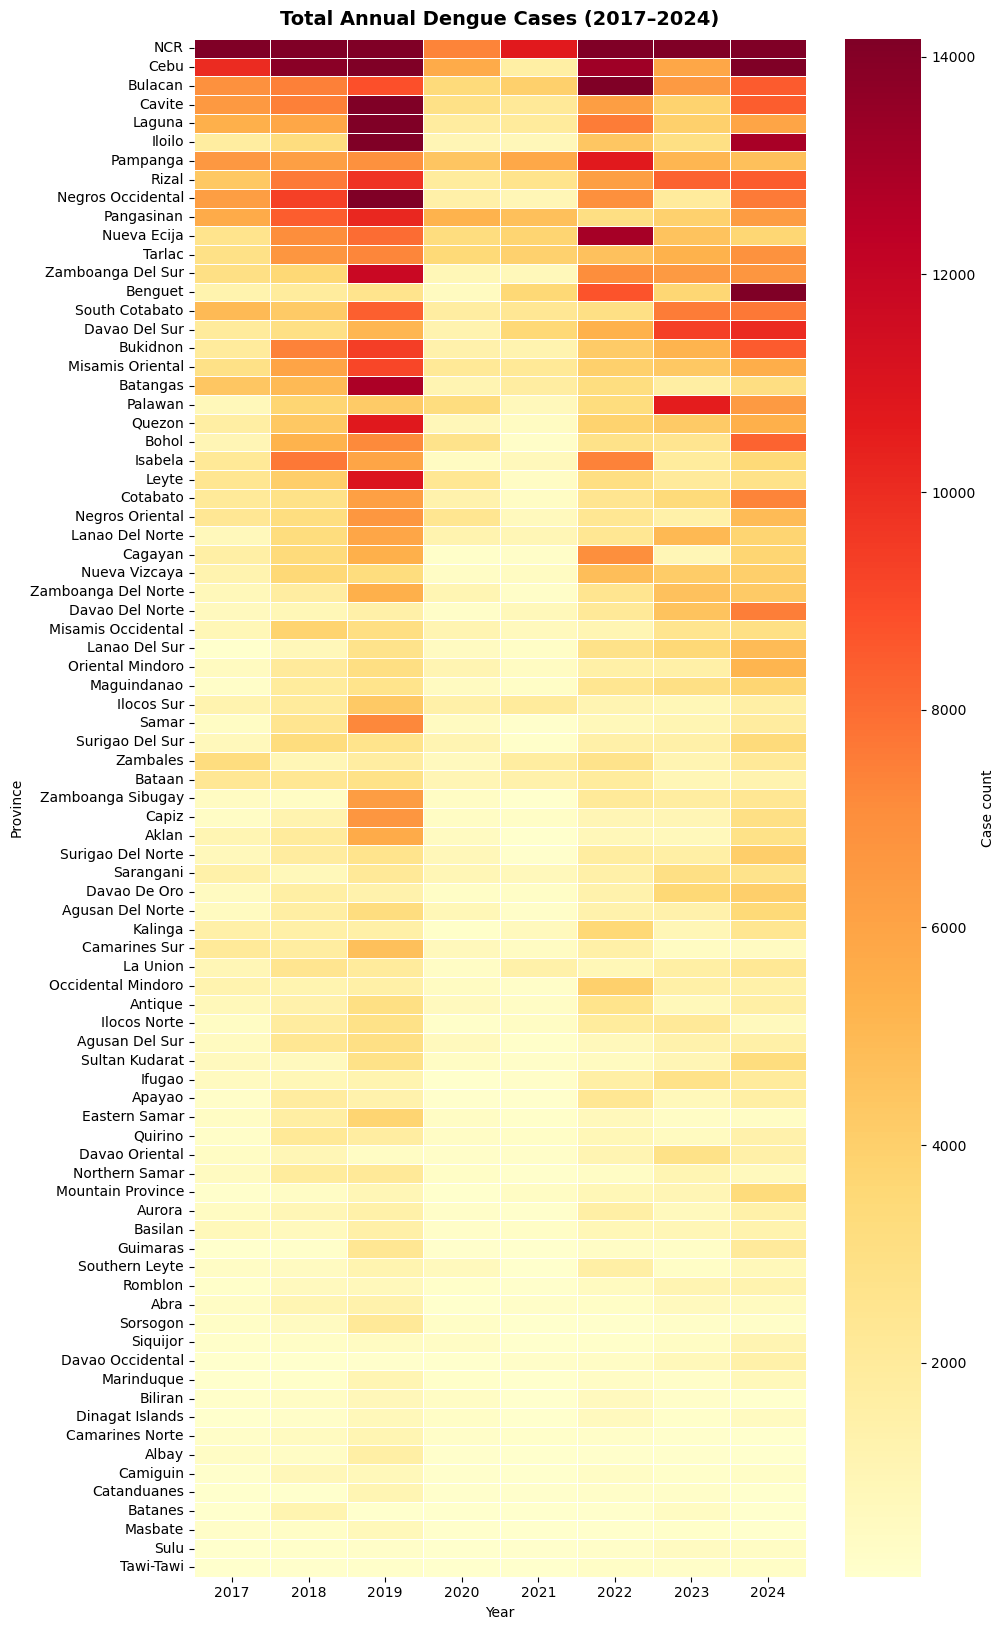

In [45]:
annual_heatmap = dengue.pivot_table(index='Province', columns='Year', values='Cases', aggfunc='sum')
province_order = annual_heatmap.mean(axis=1).sort_values(ascending=False).index
annual_heatmap = annual_heatmap.loc[province_order]

plt.figure(figsize=(10, annual_heatmap.shape[0] * 0.2))
sns.heatmap(annual_heatmap, cmap='YlOrRd', linewidths=0.5, linecolor='white', cbar_kws={'label':'Case count'}, xticklabels=annual_heatmap.columns, robust=True)
plt.title('Total Annual Dengue Cases (2017–2024)', fontsize=14, weight='bold', pad=10)
plt.xlabel('Year')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

**Next, I conducted the same analysis but on a monthly-aggregated time frame. As expected, NCR again consistently recorded the highest number of cases throughout the year, largely due to its status as the most densely-populated region in the country. The seasonal pattern also becomes more apparent in this visual, with most of the dark red cells clustered during the rainy months, particularly from July to September.**

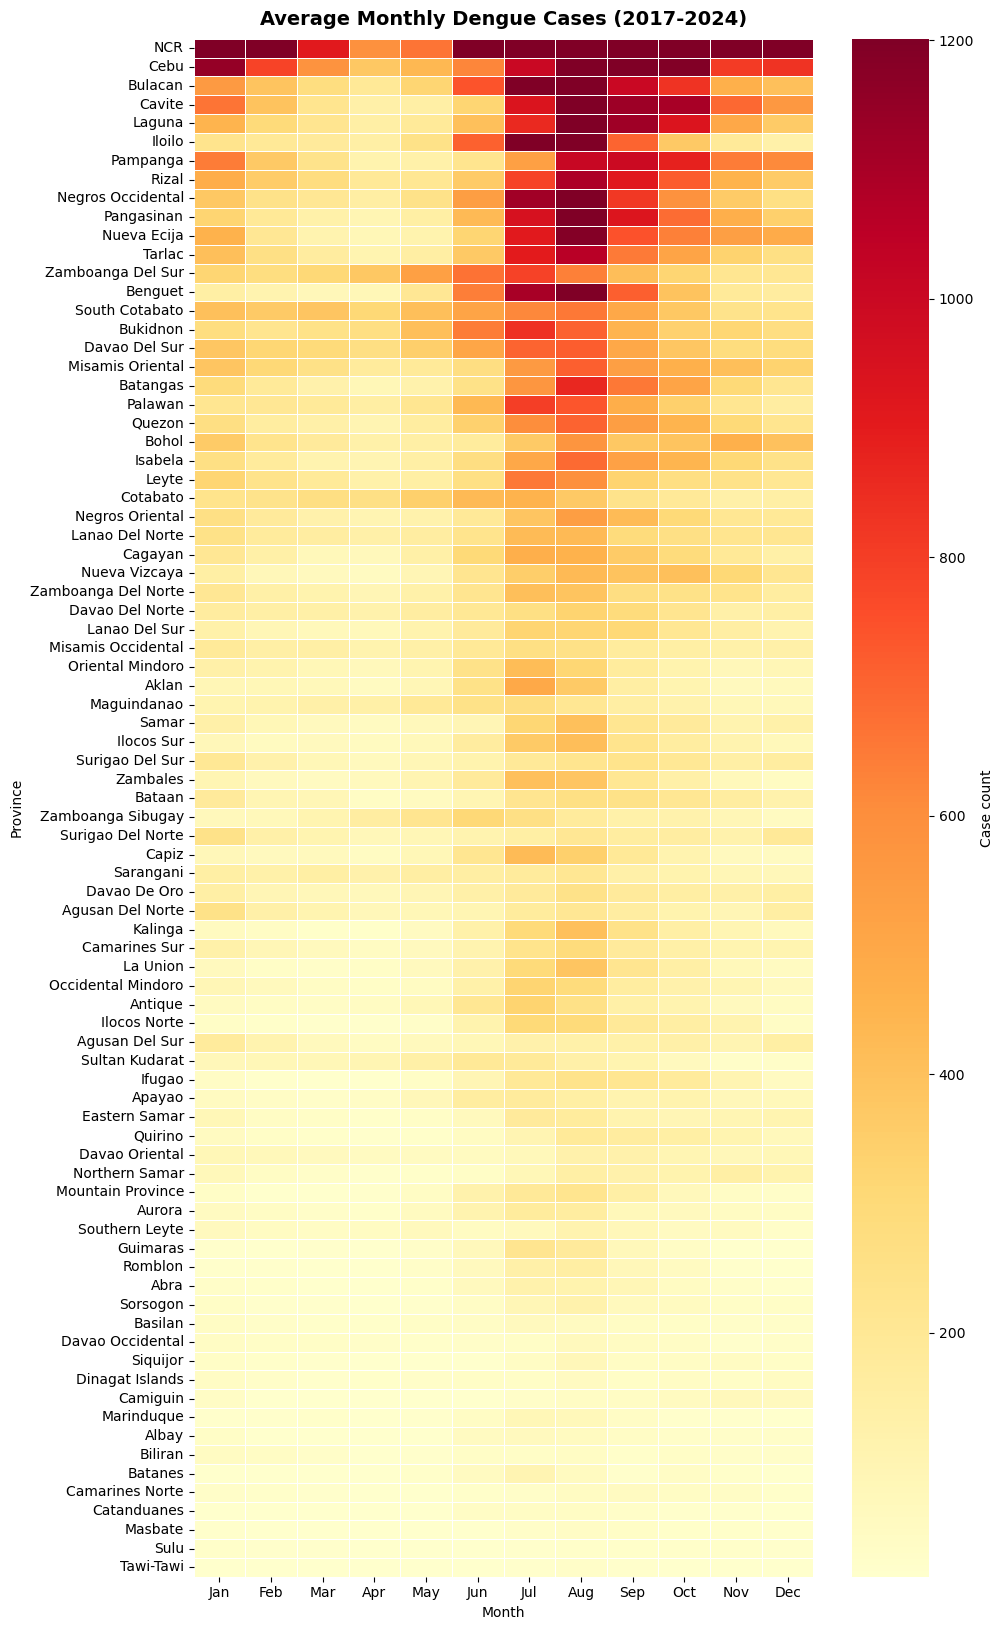

In [47]:
monthly_heatmap = dengue.pivot_table(index='Province', columns='Month', values='Cases', aggfunc='mean')
province_order = monthly_heatmap.mean(axis=1).sort_values(ascending=False).index
monthly_heatmap = monthly_heatmap.loc[province_order]

plt.figure(figsize=(10, monthly_heatmap.shape[0] * 0.2))
sns.heatmap(monthly_heatmap, cmap='YlOrRd', linewidths=0.5, linecolor='white', cbar_kws={'label':'Case count'},
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], robust=True)
plt.title('Average Monthly Dengue Cases (2017-2024)', fontsize=14, weight='bold', pad=10)
plt.xlabel('Month')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

**Wanting to extract every possible pattern or trend from the raw case counts with respect to time, I created another time-series heatmap but this time at the most granular level, including all months covered in the dataset. I then applied a K-means clustering analysis to determine whether distinct temporal profiles could be established. I experimented with n_clusters values ranging from 2 to 6, but ultimately settled on 2 as the final value.**

**The clustering algorithm struggled to identify strong, well-defined patterns, especially at higher n_cluster values (e.g. 4 or more), where the groupings became increasingly diffuse and inconclusive. However, at n_clusters = 2, we can observe two distinct groupings:**
- **Cluster 1 (majority of provinces) exhibits the typical dengue seasonality, with case spikes primarily occurring between July and September, sometimes extending a month earlier or later.**
- **Cluster 2 includes provinces with a relatively consistent dengue burden throughout most of the year, with slightly lower case numbers only around April and May.**

**Again, it is important to highlight that this clustering was based on raw case counts. Nevertheless, while this analysis do not account for population size, it is particularly thought-provoking to observe some less urbanized provinces such as Bukidnon, South Cotabato, Misamis Oriental, and even Palawan being grouped with more populous provinces, which suggests a year-round vulnerability that warrants further investigation and attention.**

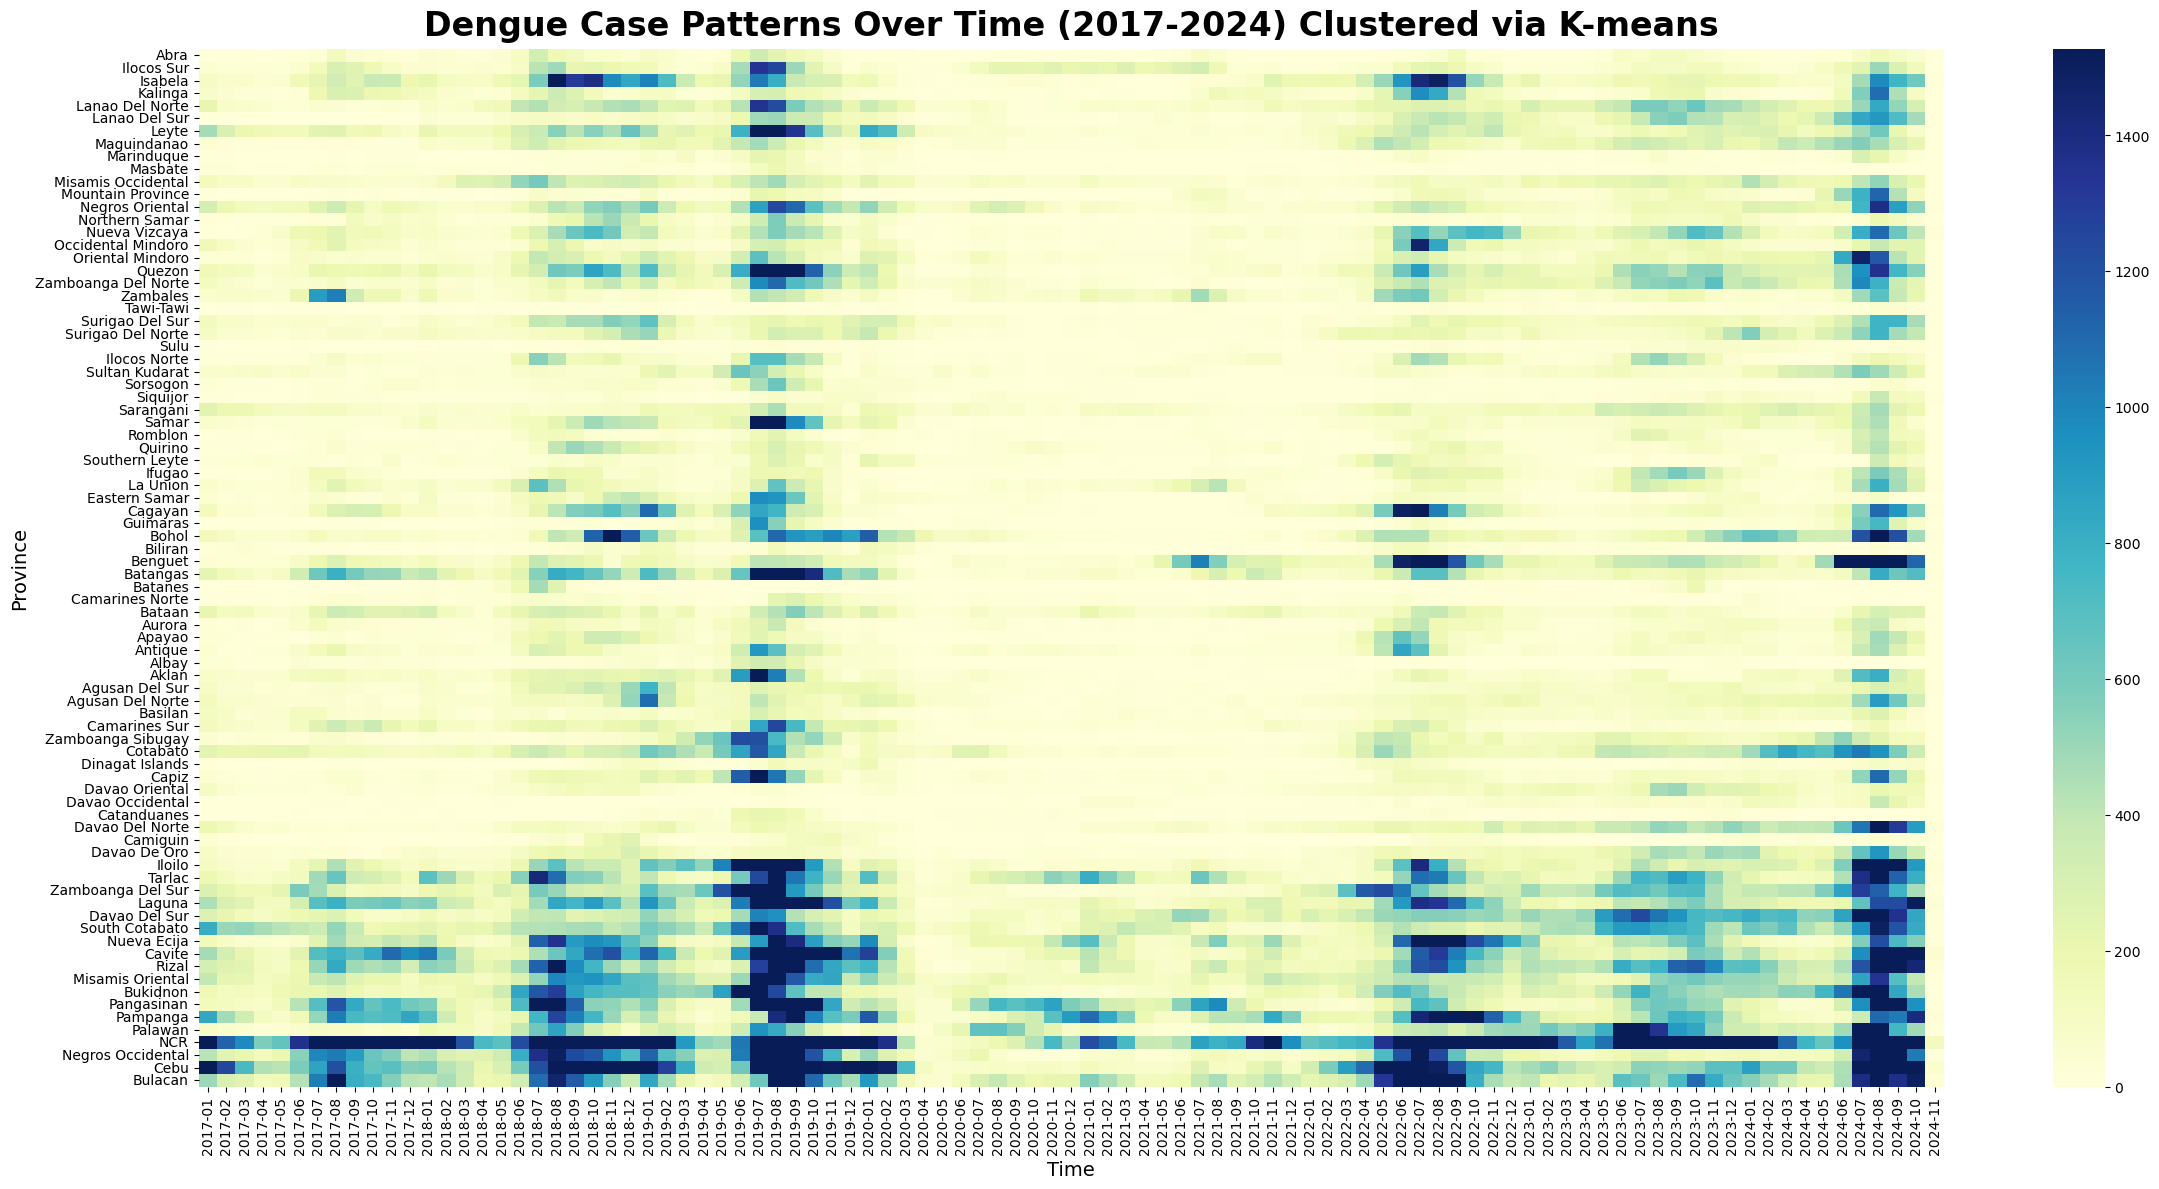

In [49]:
kmeans_pivot = dengue.pivot_table(index='Province', columns=['Year', 'Month'], values='Cases', aggfunc='sum').fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(kmeans_pivot)
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)
kmeans_pivot['Cluster'] = kmeans.labels_
kmeans_pivot_sorted = kmeans_pivot.sort_values(by='Cluster')

plt.figure(figsize=(24, 12))
xticks = [f'{year}-{month:02d}' for year, month in kmeans_pivot_sorted.columns[:-1]] 
sns.heatmap(kmeans_pivot_sorted.drop(columns='Cluster'), cmap='YlGnBu', cbar=True, robust=True, yticklabels=True, xticklabels=xticks)
plt.title('Dengue Case Patterns Over Time (2017-2024) Clustered via K-means', fontsize=24, weight="bold", pad=10)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Province', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**After identifying national and provincial dengue case patterns over time, I wanted to shift focus and explore how the disease burden across the country might evolve moving forward. To my pleasant surprise, several provinces were projected to have declining case trends. Even more surprisingly, some of the provinces with the highest absolute case counts — including NCR, Batangas, Cavite, Laguna, Negros Occidental, and Pangasinan — showed modest but clear downward trajectories. In contrast, 8 out of the top 11 provinces with rising case trends were located in the major island of Mindanao. This is noteworthy because Mindanao is known to experience rainfall over a broader time window compared to Luzon and Visayas. In fact, some areas receive substantial rainfall even during what is traditionally considered as the dry season. As the effects of climate change on weather variability and rainfall distribution become more pronounced, these projections could potentially worsen in the years ahead.**

**Another subtle but potentially important insight is the presence of four landlocked and highly-elevated provinces — including the top spot on the list — among the top 20 provinces with the steepest upward trends. This could be a significant observation since dengue transmission generally declines at higher elevations where cooler temperatures disrupts the entire mosquito life cycle as well as the dengue virus incubation itself. Moreover, these mountainous provinces are not highly populated, which suggests that rising dengue trends in these areas are likely not driven by population density, a usual risk factor in dengue transmission. While the dengue transmission cycle is known to be complex and influenced by multiple interacting factors, observations like these are crucial. They may point to overlooked vulnerabilities and may help shape more tailored public health interventions in the future.**

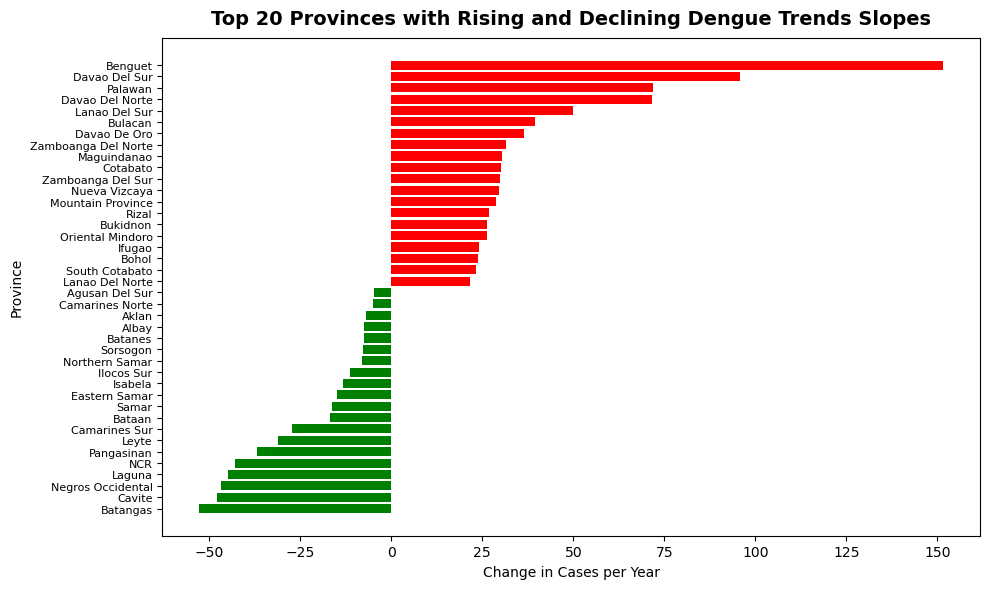

In [51]:
slopes = []
for name, group in dengue.groupby('Province'):
    X = group[['Year']]
    y = group['Cases']
    model = LinearRegression().fit(X, y)
    slopes.append((name, model.coef_[0]))

trend_df = pd.DataFrame(slopes, columns=['Province', 'Slope']).sort_values(by='Slope')
negative_slopes = trend_df.head(20) 
positive_slopes = trend_df.tail(20)

plt.figure(figsize=(10, 6))
plt.barh(negative_slopes['Province'], negative_slopes['Slope'], color='green')
plt.barh(positive_slopes['Province'], positive_slopes['Slope'], color='red')
plt.title('Top 20 Provinces with Rising and Declining Dengue Trends Slopes', fontsize=14, weight='bold', pad=10)
plt.xlabel('Change in Cases per Year')
plt.ylabel('Province')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

**At this point, several solid temporal patterns have been clearly established. However, without accounting for population, further analysis of raw case counts would yield limited meaningful insights. Hence, to explore other possible patterns, I pivoted to analyzing the statistical variability in dengue cases over time. After computing for measures of variability, the results interestingly showed a totally different set of provinces. Strikingly, there appears to be no clear unifying characteristic among most of the provinces on the list. Nonetheless, here are some information about pairs of provinces that might be noteworthy:**
- **Guimaras and Batanes are tiny island provinces**
- **Iloilo and Capiz are adjacent provinces and had unprecedented case spikes especially during 2019**
- **Sorsogon and Albay are also adjacent provinces**
- **Eastern Samar and Samar (geographically Western Samar) lie on opposite ends of the same land mass**
- **Benguet and Mountain Province are also adjacent yet they are the only land-locked provinces among the top ten**

**The diversity in location, geographical profile, population density, and possibly even the timing of case spikes indicates that there is a more complex interplay of factors that influences the apparent variability in case distribution.**

In [53]:
volatility = (dengue.groupby('Province')['Cases'].agg(['mean', 'std']).assign(cv=lambda x: x['std'] / x['mean']).sort_values(by='cv', ascending=False))
volatility.head(10)

,mean,std,cv
Province,,,
Guimaras,60.078652,154.317060,2.568584
Batanes,31.175439,76.042075,2.439166
Iloilo,565.473684,1350.893927,2.388960
Capiz,144.926316,304.349367,2.100028
Sorsogon,43.352273,90.853936,2.095713
Samar,153.968085,314.882482,2.045115
Benguet,423.084211,858.978422,2.030278
Mountain Province,78.066667,158.277512,2.027466
Albay,30.363636,60.311487,1.986306


**I then applied the variability metrics to assess how much dengue case counts fluctuated across provinces during each month of the year. Since we are still dealing with raw case counts, I expected that the rainy months would naturally exhibit higher volatility, and that was indeed the case. However, it is reasonable to expect that the same trend will likely hold even after adjusting for population. The nature of outbreaks, which is highlighted by sudden surges and declines, tends to produce wild swings regardless of population normalization.**

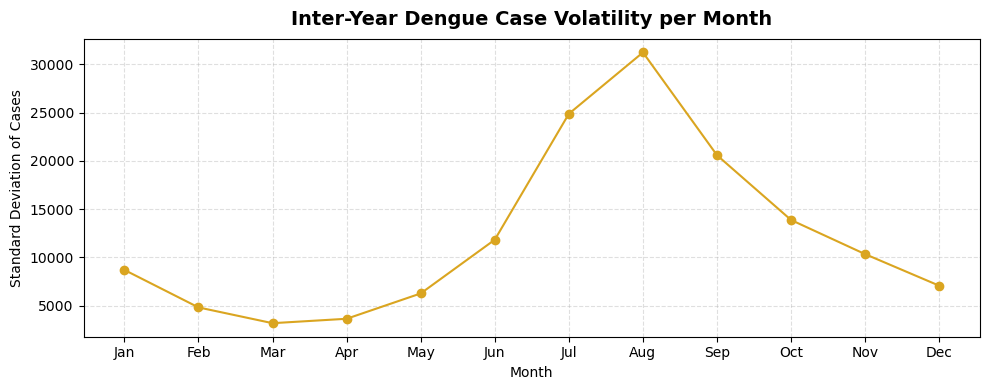

In [55]:
volatility_monthly = dengue.groupby(['Year', 'Month'])['Cases'].sum().groupby('Month').std()

plt.figure(figsize=(10, 4))
plt.plot(range(1, 13), volatility_monthly, marker='o', color='goldenrod')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Inter-Year Dengue Case Volatility per Month', fontsize=14, weight='bold', pad=10)
plt.xlabel('Month'); plt.ylabel('Standard Deviation of Cases')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout(); plt.show()

**In an effort to extract additional insights from variability measures, I did some research and came across the concept of Change Point Detection (CPD) and the "ruptures" Python library. CPD is a time series analysis technique that identifies points in time where the statistical properties of the data change significantly as determined by the algorithm used. There are several algorithms available to perform this analysis, many of which I found difficult to intuitively grasp despite reading up on them.**

**One of the more widely used methods is the Pruned Exact Linear Time (PELT) algorithm. PELT is known for being computationally-efficient, more straightforward compared to other methods, and relatively easier to interpret. It detects subtle changes by maintaining a minimal cost function while applying a penalty term to avoid overfitting and labeling a change point in an otherwise noisy segment of the time series. Within the PELT method, various models can be used to measure change. After testing three different models (l1, l2, and rbf), I chose the rbf model because it provided the most consistent results across all 82 provinces using a single penalty value. While a more localized analysis, i.e. focusing on just one province, might benefit from a different model or customized tuning, the rbf model provided a balanced and generalizable approach for this broader comparative study.**

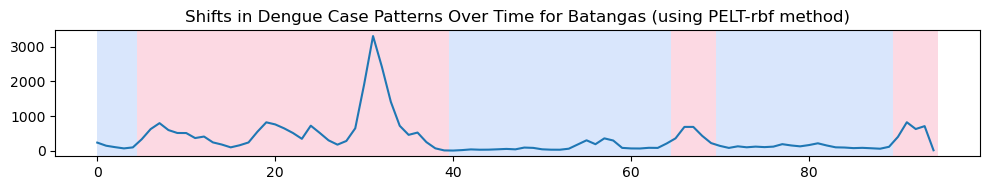

Change points detected (rbf): [5, 40, 65, 70, 90, 95]


In [57]:
province = 'Batangas'  # change the province name here
penalty = 2      # change the penalty value here
signal = dengue[dengue['Province'] == province]['Cases'].values

algo_rbf = rpt.Pelt(model="rbf").fit(signal)
result_rbf = algo_rbf.predict(pen=penalty)

rpt.display(signal, result_rbf)
plt.title(f"Shifts in Dengue Case Patterns Over Time for {province} (using PELT-rbf method)")
plt.tight_layout()
plt.show()
print("Change points detected (rbf):", result_rbf)

**The Change Point Detection model turned out to be a quite satisfying tool to explore. I noticed that many of the detected “change points” were not always visually obvious, that is, I wouldn’t have been able to confidently identify them via manual inspection. However, once I understood the statistical criteria that the model follows, I gained a deeper appreciation for what the visual was demonstrating.**

**In a practical sense, this analysis answers a key real-world question: for a given province, when or at what point do the dengue case patterns shift significantly? While the model isn’t necessarily designed for forecasting future outbreaks, its ability to reliably recognize shifts in patterns may still offer valuable insights for public health planning.**

**To wrap up this section of the project, I saved the dengue dataframe to be used for the latter comprehensive analysis.**

In [59]:
dengue.to_csv("dengue.csv", index=False)